# Digit Classification with KNN and Naive Bayes

## Import Libraries

In [3]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

import matplotlib
import decimal
from scipy import stats
from sklearn.metrics import accuracy_score, make_scorer

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

C:\Users\tyu\Anaconda3\envs\ipykernel_py2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\tyu\Anaconda3\envs\ipykernel_py2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Split the data

In [4]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST (original)', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

#print(mini_train_data[0])
#print(mini_train_labels[0])

data shape:  (70000L, 784L)
label shape: (70000L,)


In [5]:
print (mini_train_data[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

## EDA

### Visualizing the Numbers

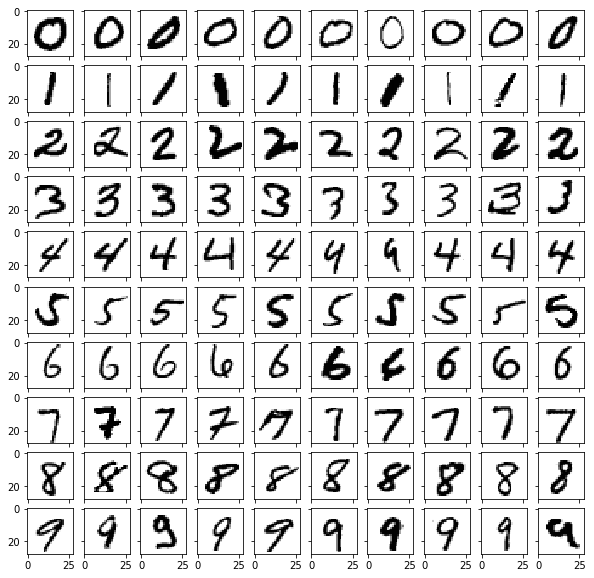

In [3]:
number_samples = {}

for index,label in enumerate(mini_train_labels):
    if label not in number_samples:
        number_samples[label] = []
    else:
        if len(number_samples[label]) < 10:
            number_samples[label].append(index)
        else:
            continue 

# Plotting the image of the sample numbers collected above. 
            
f, axarr = plt.subplots(10, 10, figsize=(10,10), sharex=True, sharey=True)
            
for i, values in number_samples.items():
    for j, index in enumerate(values):
        digit = mini_train_data[index].reshape(28,28)
        axarr[int(i), int(j)].imshow(digit, cmap = matplotlib.cm.binary)


### Using knn to check initial accuracy

In [4]:
k_values = [1, 3, 5, 7, 9]
outcomes = {}
cls_reports = {}

for k in k_values:
    cls = KNeighborsClassifier(n_neighbors=k)
    cls.fit(mini_train_data, mini_train_labels)
    
    predictions = cls.predict(dev_data)
    accuracy = accuracy_score(dev_labels, predictions)
    outcomes[k] = accuracy
    cls_reports[k] = classification_report(dev_labels, predictions)

print outcomes
print "\nIt seems like k=1 is the best result on the dev set after training on the mini set.\n"
    
# Showing the precision, recall, and F1 for each label.

print cls_reports[1]


{1: 0.888, 3: 0.878, 9: 0.863, 5: 0.869, 7: 0.865}

It seems like k=1 is the best result on the dev set after training on the mini set.

             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.89      1.00      0.94       105
        2.0       0.99      0.79      0.88       102
        3.0       0.77      0.87      0.82        86
        4.0       0.89      0.82      0.85       104
        5.0       0.93      0.84      0.88        91
        6.0       0.94      0.96      0.95        98
        7.0       0.89      0.92      0.90       113
        8.0       0.94      0.88      0.91        96
        9.0       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000



k=1 seems to be the best. The algorithm seems to have really struggled with 9.

### Looking at training time with k=1 with increasing sample size

In [5]:
#def P3(train_sizes, accuracies):

### STUDENT START ###

# Defining initial variables

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
time2train = {}
outcomes = {}

# Training the data and collecting accuracy and time results

for train_size in train_sizes:
    train_data_temp = train_data[:train_size]
    train_labels_temp = train_labels[:train_size]
    
    cls = KNeighborsClassifier(n_neighbors=1)
    
    start = time.time()
    cls.fit(train_data_temp, train_labels_temp)
    stop = time.time()
    
    time2train[train_size] =  round(stop - start,5)
    
    predictions = cls.predict(dev_data)
    accuracy = accuracy_score(dev_labels, predictions)
    outcomes[train_size] = accuracy   

# Reporting the accuracy and time results  
    
print "The below are the times it took to train with the different training sizes: "
print time2train

print "The below are the accuracies with the different training sizes: "
print outcomes

The below are the times it took to train with the different training sizes: 
{1600: 0.037, 3200: 0.123, 100: 0.002, 200: 0.002, 6400: 0.274, 400: 0.007, 25000: 3.707, 12800: 1.055, 800: 0.011}
The below are the accuracies with the different training sizes: 
{1600: 0.902, 3200: 0.926, 100: 0.72, 200: 0.786, 6400: 0.937, 400: 0.841, 25000: 0.97, 12800: 0.959, 800: 0.884}


#### Plotting the above results

[[1.24307226]]
[[1.03386514]]


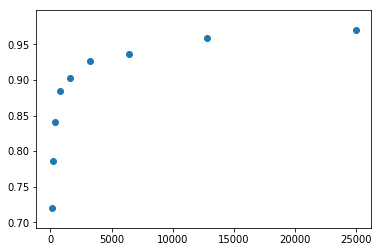

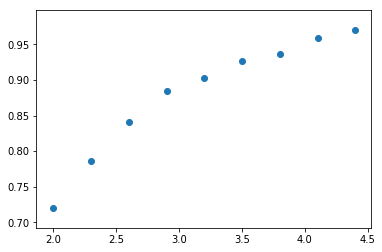

In [6]:
size_val = [x[0] for x in sorted(outcomes.items())]
accuracy_val = [x[1] for x in sorted(outcomes.items())]

# Graphing the linear relationship between size and accuracy. 

fig1, ax1 = plt.subplots()
ax1.scatter(size_val, accuracy_val)

cls = LinearRegression()
X = np.array(size_val).reshape(-1,1)
Y = np.array(accuracy_val).reshape(-1,1)

cls.fit(X,Y)
print cls.predict(60000)

# Log transforming the independent variable and remodeling the data. 

fig2, ax2 = plt.subplots()
ax2.scatter(np.log10(size_val), accuracy_val)

cls2 = LinearRegression()
X2 = np.array(np.log10(size_val)).reshape(-1,1)
Y2 = np.array(accuracy_val).reshape(-1,1)

cls.fit(X2,Y2)
print cls.predict(np.log10(60000))

It looks like a size of about 7500 is good.

### Looking at the potential wrong classifications

Confusion Matrix:
[[ 99   0   0   0   0   0   0   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  1   0  98   2   0   0   0   1   0   0]
 [  0   0   0  83   0   1   0   0   1   1]
 [  0   0   0   0 102   0   0   0   0   2]
 [  1   0   0   0   0  88   0   0   1   1]
 [  1   0   0   0   1   0  96   0   0   0]
 [  0   0   1   0   0   0   0 111   0   1]
 [  1   0   1   2   0   2   1   0  89   0]
 [  0   0   0   0   0   0   0   0   0 106]]
[40, 62, 170, 244, 440]


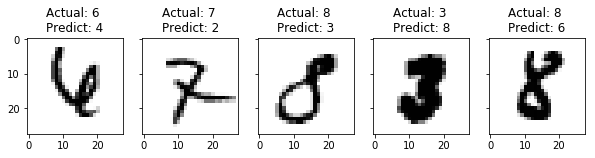

In [7]:
cls = KNeighborsClassifier(n_neighbors=1)
    
cls.fit(train_data, train_labels)
predictions = cls.predict(dev_data)

print "Confusion Matrix:"
print confusion_matrix(dev_labels, predictions)

# Finding unmatched values and plotting 5 of them:

mistakes = []
number_mistakes = 5
    
for index, (true_val, pred_val) in enumerate(zip(dev_labels, predictions)):
    if true_val != pred_val and len(mistakes) < number_mistakes:
        mistakes.append(index)

print mistakes

f, axarr = plt.subplots(1, number_mistakes, figsize=(10,10), sharex=True, sharey=True)
col = 0
            
for i in mistakes:
    digit = dev_data[i].reshape(28,28)
    axarr[col].imshow(digit, cmap = matplotlib.cm.binary)
    axarr[col].set_title('Actual: %d \nPredict: %d' % (dev_labels[i],predictions[i]))
    
    col += 1

### Creating a blur function according to below instructions from previous work...

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. The following 3 ways are tried:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

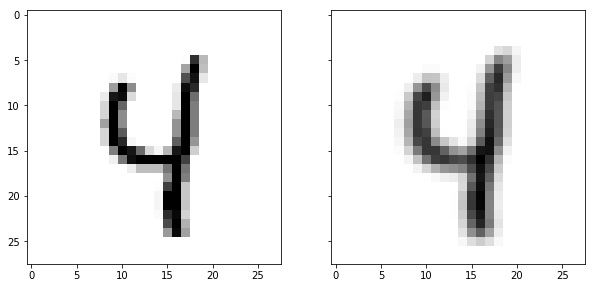

In [8]:
def find_weight(a,b):
    if abs(a) == 1 and abs(b) == 1:
        return 1
    elif a == 0 and b ==0:
        return 4
    else:
        return 2

def blurring(image_vector):
    transformed_vector = image_vector.reshape(28,28)
    
    blurred_vector = np.zeros((28,28))
    
    positions = [(-1,-1), (-1,0), (-1,1), (0,-1), (0,0), (0,1), (1,-1), (1,0), (1,-1)]
    
    for index_i, row in enumerate(transformed_vector):
        for index_j, col in enumerate(row):
            
            new_pixel = 0
            counter = 0
            
            for (a,b) in positions:
                
                if 27 >= index_i + a >= 0 and 27 >= index_j + b >=0 :
                    new_pixel += transformed_vector[index_i + a, index_j + b] * find_weight(a,b)
                    counter += find_weight(a,b)
                else:
                    continue
                
            blurred_vector[index_i, index_j] = new_pixel/counter
            #print(transformed_vector[index_i, index_j], blurred_vector[index_i, index_j])
    
    return blurred_vector.flatten()


# The below is a test for the above function

test_image = dev_data[0]
test_normal_image = test_image.reshape(28,28)
test_blurred_image = blurring(test_image)
test_blurred_image = test_blurred_image.reshape(28,28)

f, axarr = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)
axarr[0].imshow(test_normal_image, cmap = matplotlib.cm.binary)
axarr[1].imshow(test_blurred_image, cmap = matplotlib.cm.binary)

In [9]:
# Creating the blurred image sets 

print "Begin blurring."

blur_train = []
blur_dev = []

for v in train_data:
    blur_train.append(blurring(v))
    
for v in dev_data:
    blur_dev.append(blurring(v))
    
print "Finished blurring."

Begin blurring.
Finished blurring.


In [10]:
# Doing the training on blurred and non-blurred sets. 

cls = KNeighborsClassifier(n_neighbors=1)
    
# Train blurred, dev same    
cls.fit(blur_train, train_labels)
predictions = cls.predict(dev_data)
accuracy = accuracy_score(dev_labels, predictions)

print "Training blurred and Dev same resulted in an accuracy of ", accuracy

# Train same, dev blurred    
cls.fit(train_data, train_labels)
predictions = cls.predict(blur_dev)
accuracy = accuracy_score(dev_labels, predictions)

print "Training same and Dev blurred resulted in an accuracy of ", accuracy

# Train blurred, dev blurred    
cls.fit(blur_train, train_labels)
predictions = cls.predict(blur_dev)
accuracy = accuracy_score(dev_labels, predictions)

print "Training blurred and Dev blurred resulted in an accuracy of ", accuracy

Training blurred and Dev same resulted in an accuracy of  0.981
Training same and Dev blurred resulted in an accuracy of  0.962
Training blurred and Dev blurred resulted in an accuracy of  0.981


It seems that having the training blurred and the dev the same was the best. This makes sense intuitively because blurring would essentially increase the ability for the algorithm to detect potential outlier cases since we are expanding the training data so to speak. This is contrast to blurring the dev data set and leaving the training set the same. Because the training doesn't contain any extreme cases, it has a hard time predicting blurred images. With blurring both sets, results were between the two other cases. It generally performed well though. 

### Trying Naive Bayes (Binomial + Multinomial)

In [11]:
for i in range(0,5):
    print(np.amax(mini_train_data[i]), np.amin(mini_train_data[i]))

# A cutoff of 0.5 was decided because the pixel values seem to range from 0 to 1. 
def Bernoulli_trans(v):
    pixel_matrix = np.zeros(v.shape)

    pixel_matrix[(v <= 0.5)] = 0
    pixel_matrix[(v > 0.5)] = 1
    
    return pixel_matrix

# Cutoffs of 0.33 and 0.67 were decided because the pixel values seem to range from 0 to 1. 
def Multinomial_trans(v):
    pixel_matrix = np.zeros(v.shape)

    pixel_matrix[(v <= 0.33)] = 0
    pixel_matrix[(v <= 0.67)&(v>0.33)] = 1
    pixel_matrix[(v > 0.67)] = 2
    
    return pixel_matrix

# Transforming the data
train_data_Bernoulli = []
train_data_Multinomial = []
dev_data_Bernoulli = []
dev_data_Multinomial = []
mini_train_Bernoulli = []
mini_train_Multinomial = []


for v in train_data:
    train_data_Bernoulli.append(Bernoulli_trans(v))
    train_data_Multinomial.append(Multinomial_trans(v))
    
for v in dev_data:
    dev_data_Bernoulli.append(Bernoulli_trans(v))
    dev_data_Multinomial.append(Multinomial_trans(v))

# Training this for use in P8.
for v in mini_train_data:
    mini_train_Bernoulli.append(Bernoulli_trans(v))
    mini_train_Multinomial.append(Multinomial_trans(v))


# Model training, prediction, and reporting on the accuracy 
cls = BernoulliNB()

cls.fit(train_data_Bernoulli, train_labels)
predictions = cls.predict(dev_data_Bernoulli)
accuracy = accuracy_score(dev_labels, predictions)

print "The accuracy using Bernoulli is ", accuracy

cls = MultinomialNB()

cls.fit(train_data_Multinomial, train_labels)
predictions = cls.predict(dev_data_Multinomial)
accuracy = accuracy_score(dev_labels, predictions)

print "The accuracy using Multinomial is ", accuracy

(1.0, 0.0)
(1.0, 0.0)
(0.996078431372549, 0.0)
(1.0, 0.0)
(1.0, 0.0)
The accuracy using Bernoulli is  0.845
The accuracy using Multinomial is  0.825


Multinomial doesn't seem to improve the results. The reason could be overfitting and a lack of generalization when predicting the development set. Multinomial naive Bayes model is typically used for discrete counts whereas here we have more of a binary system. Ie. Is the predicted number correct? Yes or No. 

### Try Laplace Smoothing

In [13]:
# Training the data with mini set

cls = BernoulliNB()
parameters = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}

grid_obj = GridSearchCV(cls, parameters, scoring=make_scorer(accuracy_score))
grid_obj = grid_obj.fit(mini_train_Bernoulli, mini_train_labels)


# Reporting the best paramter
print "The best alpha seems to be: ", grid_obj.best_params_

# Using the trained data to predict the dev data 
cls = grid_obj.best_estimator_

predictions = cls.predict(dev_data_Bernoulli)
accuracy = accuracy_score(dev_labels, predictions)

print "The accuracy seems to be: ", accuracy, " when using the dev data."

The best alpha seems to be:  {'alpha': 0.01}
The accuracy seems to be:  0.818  when using the dev data.


With the mini training set, the alpha recommended is 0.01. 

### Testing generative property of NB

10


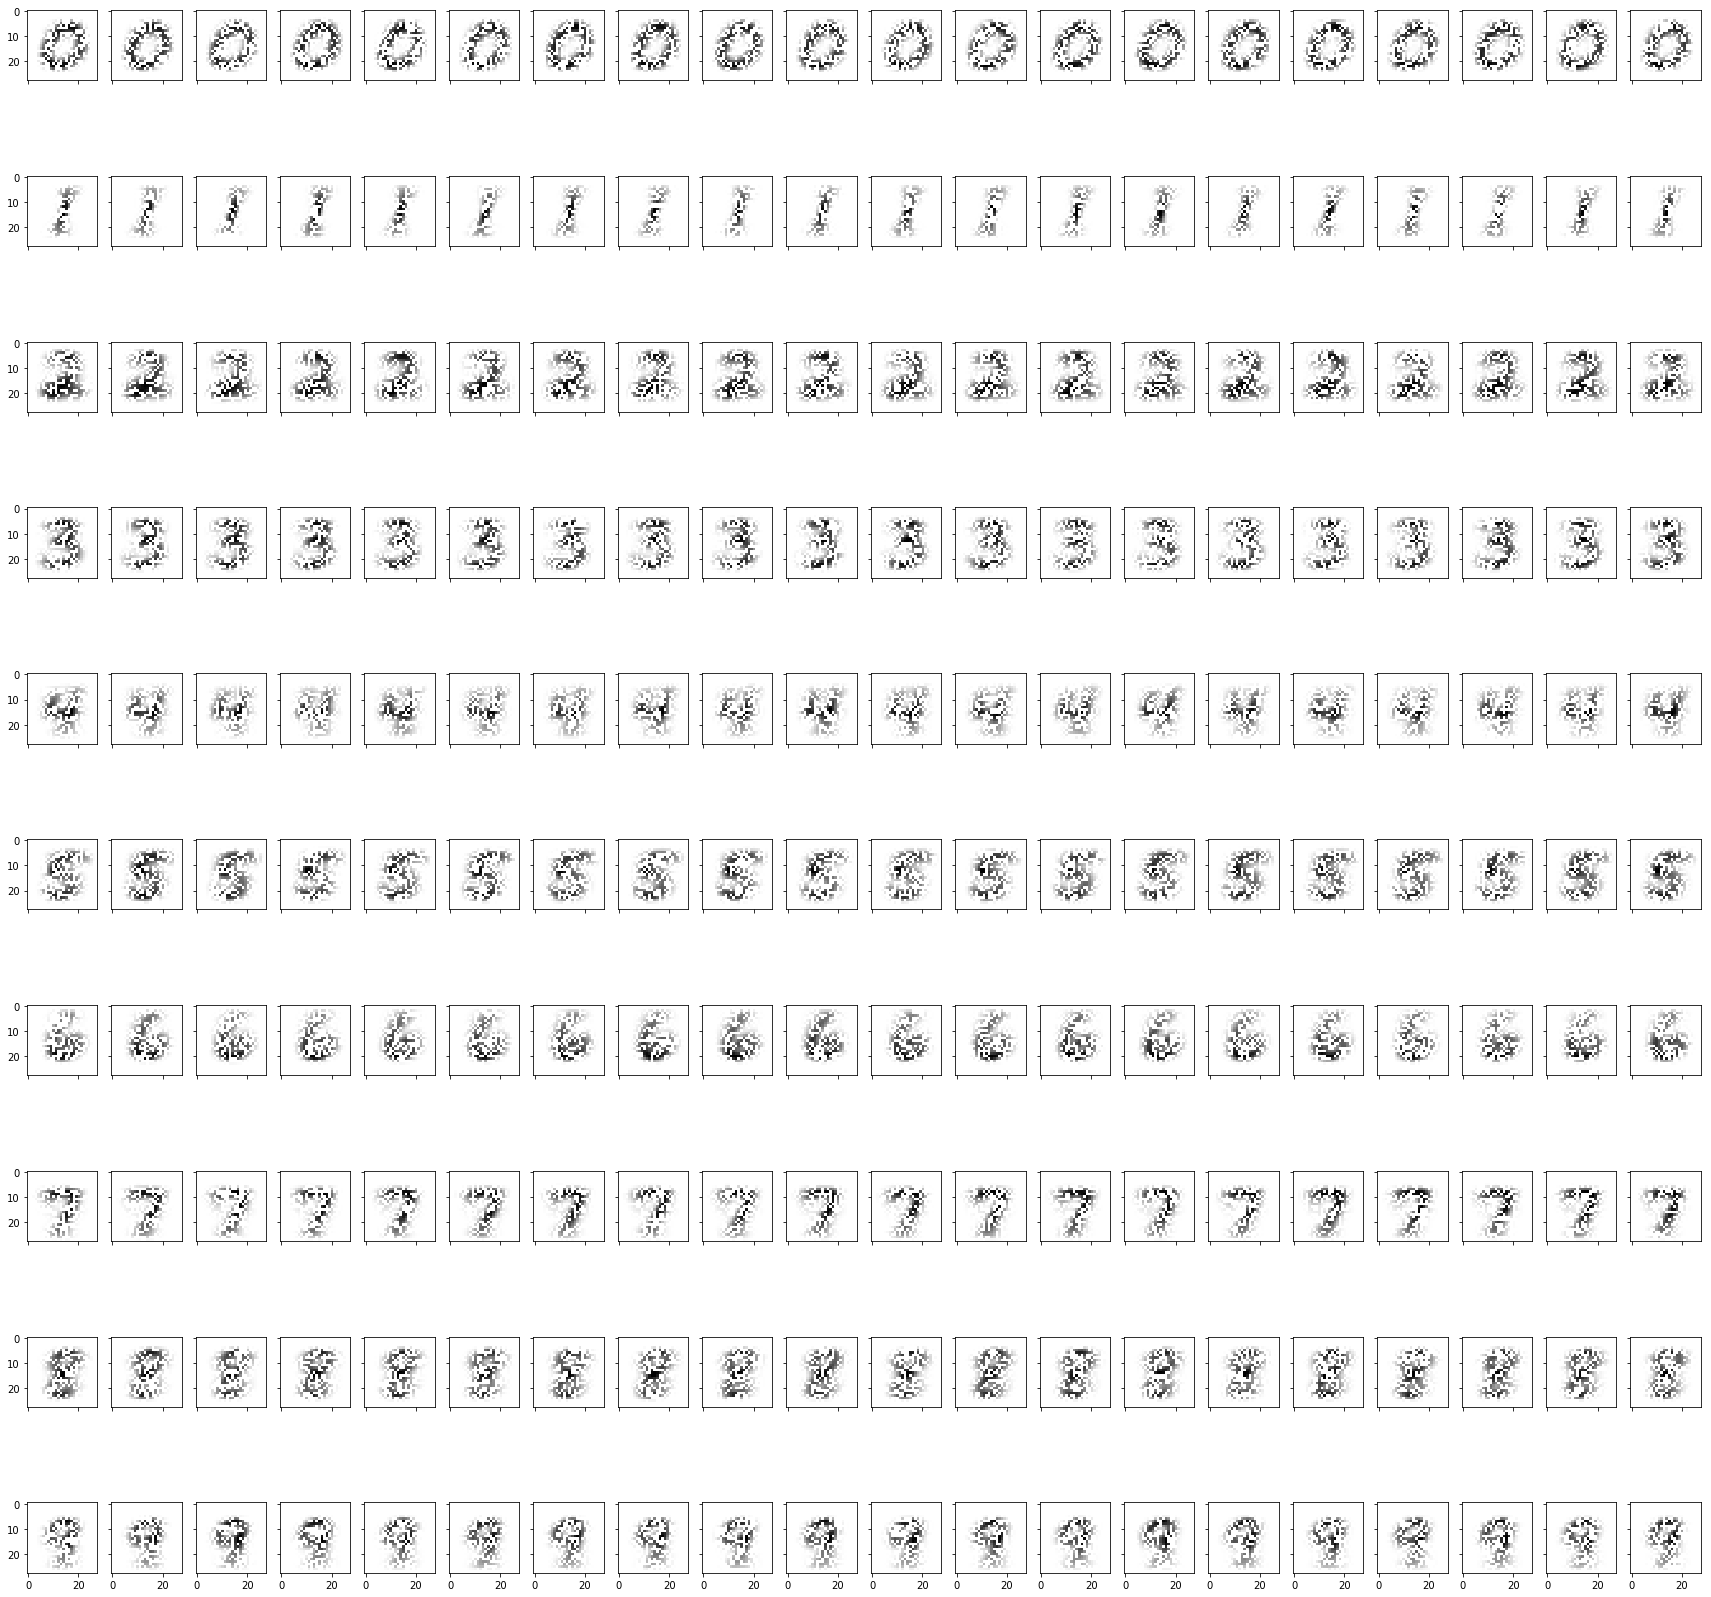

In [16]:
cls = BernoulliNB()
cls.fit(train_data_Bernoulli, train_labels)

# Confirm the number of vectors. There seems to be 10 values. One for each number.
print len(cls.feature_log_prob_) 

# Graphing random variations of the number according to the feature probabilities
f, axarr = plt.subplots(10, 20, figsize=(30,30), sharex=True, sharey=True)

for x in range(0, len(cls.feature_log_prob_)):
    for i in range(0,20):
        
        bern_v = np.exp(cls.feature_log_prob_[x])
        
        #This part was tried with binary and non-binary numbers.
        # r_numb_v = np.random.rand(size=len(bern_v))
        r_numb_v = np.random.randint(2,size=len(bern_v))
        
        image_v = bern_v * r_numb_v
        
        digit = image_v.reshape(28,28)
        axarr[x, i].imshow(digit, cmap = matplotlib.cm.binary)

It's easy to see how the computer would confuse a 3 and an 8. There may be some error when distinguishing between a 4 and a 9 as well but overall quite good. Numbers with very distinct shapes like 7 and 5s come out very well. Again, this part was tried with both binary values and non-binary values and with non-binary values because there are more choices for numbers, the images do appear clearer but overall the message is the same. 

### Characterizing the calibration of the NB model

In [17]:
cls = BernoulliNB(alpha = 0)

cls.fit(train_data_Bernoulli, train_labels)
predictions = cls.predict(dev_data_Bernoulli)


# Defining variables, counters, and initializing lists and dictionaries.  
buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
buckets = sorted(buckets)

bucket_counter = {}
bucket_temp = []

for bucket in buckets:
    bucket_temp.append(bucket)
    bucket_counter[bucket] = {'correct':0, 'total':0}
    
# Updating the list and counters based on the prediction results  
for v, p, l in zip(cls.predict_proba(dev_data_Bernoulli), predictions, dev_labels):
    max_postprob = max(v)
    
    bucket_temp.append(max_postprob)
    #print(sorted(bucket_temp))
    position = sorted(bucket_temp).index(max_postprob)
    #print(sorted(bucket_temp).index(max_postprob))
    
    bucket_counter[float(buckets[position])]['total'] += 1
    
    if p == l: 
        bucket_counter[float(buckets[position])]['correct'] +=1 
    else:
        pass 
    
    bucket_temp.remove(max_postprob)
    #print(sorted(bucket_temp))
    
# Outputting the results   
for bucket, values in sorted(bucket_counter.items()):
    accuracy = round(float(values['correct'])/float(values['total']),2)
    print "Bucket:", bucket, "Total:", values['total'], "Correct:", values['correct'], "Accuracy:", accuracy

print("\nNote that the 0.9999999999999 bucket is being rounded to a 1. This is confirmed by looking at the original dictionary. There seems to be a 12 decimal limit in Python.\n")    
print(bucket_counter.items())

Bucket: 0.5 Total: 3 Correct: 1 Accuracy: 0.33
Bucket: 0.9 Total: 39 Correct: 23 Accuracy: 0.59
Bucket: 0.999 Total: 97 Correct: 48 Accuracy: 0.49
Bucket: 0.99999 Total: 74 Correct: 47 Accuracy: 0.64
Bucket: 0.9999999 Total: 64 Correct: 46 Accuracy: 0.72
Bucket: 0.999999999 Total: 69 Correct: 59 Accuracy: 0.86
Bucket: 0.99999999999 Total: 76 Correct: 68 Accuracy: 0.89
Bucket: 1.0 Total: 81 Correct: 74 Accuracy: 0.91
Bucket: 1.0 Total: 497 Correct: 484 Accuracy: 0.97

Note that the 0.9999999999999 bucket is being rounded to a 1. This is confirmed by looking at the original dictionary. There seems to be a 12 decimal limit in Python.

[(0.5, {'total': 3, 'correct': 1}), (1.0, {'total': 497, 'correct': 484}), (0.999, {'total': 97, 'correct': 48}), (0.9999999, {'total': 64, 'correct': 46}), (0.999999999, {'total': 69, 'correct': 59}), (0.9, {'total': 39, 'correct': 23}), (0.9999999999999, {'total': 81, 'correct': 74}), (0.99999, {'total': 74, 'correct': 47}), (0.99999999999, {'total': 76, '

The model appears to be fairly well calibrated at the end with the accuracy increasing with each successive bucket. Most examples also fall into the 1 bucket meaning that the algorithm is predicting the numbers with high levels of confidence. 